## IBM Data Science Professional Certification

### Capstone Project

This Jupyter notebook will contain all work pertaining to the capstone project for the IBM Data Science Professional Certification.

### Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import requests
import random

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [3]:
# !conda install -c conda-forge geopy --yes 
# from geopy.geocoders import Nominatim

import re
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import json # library to handle JSON files

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

print('Libraries imported.')

Libraries imported.


In [4]:
# !conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
import gensim

print('Folium and gensim installed.')

Folium and gensim installed.


### Define Foursquare Credentials and Version

In [5]:
# Foursquare credentials

CLIENT_ID = 'PFO31YQRTZSYLTTDAZTCGWJQZFHPFMQHN23RT1MXESWCAFSZ' # your Foursquare ID
CLIENT_SECRET = 'YTUXP4FXZSXJOGC122YWJQL4P5YKJQK4Y4J0LO25R2MNXZJL' # your Foursquare Secret
VERSION = '20200320'
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: PFO31YQRTZSYLTTDAZTCGWJQZFHPFMQHN23RT1MXESWCAFSZ
CLIENT_SECRET:YTUXP4FXZSXJOGC122YWJQL4P5YKJQK4Y4J0LO25R2MNXZJL


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['University', 
                  'University Latitude', 
                  'University Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Choosing a University in the United States

## Introduction

Students have several considerations in choosing a university. Aside from the availability of their degree program, students also consider the accessibility of various locations from the university campus. In this analysis, we will use location data to find out which types of establishments are frequently found near some universities in the United States, and whether we can group universities based on the types of places near to them.

## Data

This analysis will use location data from Foursquare and will examine vicinities of more than 150 universities in California. A clustering algorithm will be used to uncover and examine patterns in these locations.

## Methodology
First, the `read_html()` function from `pandas` will be used to get coordinates for 49 universities from `latlong.net`.

In [7]:
uni_coord = pd.DataFrame(pd.read_html('https://www.latlong.net/category/universities-236-47.html')[0]) \
.rename(columns={"Place Name": "University"})
uni_coord.head()

,University,Latitude,Longitude
0,"Utah Valley University, Orem, UT, USA",40.277779,-111.713890
1,"Indiana University of Pennsylvania, Indiana, P...",40.617001,-79.160004
2,"University of Illinois, Champign - Urbana, Ili...",40.110558,-88.228333
3,"Massachusetts Institute of Technology, Cambrid...",42.360001,-71.092003
4,"Stanford University, CA, USA",37.428230,-122.168861


Let's visualize the universities using Folium.

In [8]:
latitude=39.50
longitude=-98.35

uni_map = folium.Map(location=[latitude, longitude], zoom_start=3)

for lat, lng, label in zip(uni_coord['Latitude'], uni_coord['Longitude'], uni_coord['University']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(uni_map)
    
uni_map

### Exploring the data from Foursquare

Now, let's get nearby venues for each university from the Foursquare database using the `getNearbyVenues` function.

In [9]:
uni_venues = getNearbyVenues(names=uni_coord['University'], latitudes=uni_coord['Latitude'], longitudes=uni_coord['Longitude'])

In [10]:
uni_venues.head()

,University,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Utah Valley University, Orem, UT, USA",40.277779,-111.71389,Brent Brown Ballpark,40.277071,-111.717555,Baseball Stadium
1,"Utah Valley University, Orem, UT, USA",40.277779,-111.71389,UVU Student Life & Wellness Center,40.279530,-111.715150,College Gym
2,"Utah Valley University, Orem, UT, USA",40.277779,-111.71389,Jamba Juice,40.279003,-111.716202,Juice Bar
3,"Utah Valley University, Orem, UT, USA",40.277779,-111.71389,Wendy’s,40.274607,-111.715043,Fast Food Restaurant
4,"Utah Valley University, Orem, UT, USA",40.277779,-111.71389,UVU Fulton Library,40.281047,-111.716629,College Library


In [11]:
print(uni_venues.shape)

(1102, 7)


In [12]:
uni_venues.replace({'Venue Category': r'.*Joint$'}, {'Venue Category': 'Food Service'}, regex=True, inplace=True)
uni_venues.replace({'Venue Category': r'^Poke.*'}, {'Venue Category': 'Food Service'}, regex=True, inplace=True)
uni_venues.replace({'Venue Category': r'.*Pool$'}, {'Venue Category': 'Pool'}, regex=True, inplace=True)
uni_venues.replace({'Venue Category': r'^Beer.*'}, {'Venue Category': 'Beer Place'}, regex=True, inplace=True)

In [13]:
df_count = pd.DataFrame(uni_venues.groupby('University').count()) \
.rename(columns={"Venue":"Venue Count"})

df_count[['Venue Count']]

,Venue Count
University,
"Arizona State University, Tempe, AZ, USA",39
"Auburn University, Auburn, AL, USA",4
"Boise State University, Boise, ID, US",11
"Brown University, Providence, RI, USA",66
"California Institute of Technology, Pasadena, CA, USA",13
"Dixie State University, St. George, UT, USA",4
"Eastern University, St Davids, PA, USA",1
"Harvard University, Cambridge, MA, USA",100
"Indiana University of Pennsylvania, Indiana, PA, the USA",12


In [14]:
df_count[['Venue Count']].sum(axis=0)

Venue Count    1102
dtype: int64

In [15]:
print('There are {} unique venue categories.'.format(len(uni_venues['Venue Category'].unique())))

There are 203 unique venue categories.


## Using gensim to cluster similar venue categories

A pre-trained model will be used to cluster similar venue categories together.

In [16]:
df_venue = pd.DataFrame(uni_venues.groupby('Venue Category').count()) \
.rename(columns={"Venue": "Venue Count"})

df_venue[['Venue Count']].head(25)

,Venue Count
Venue Category,
ATM,2
Accessories Store,1
American Restaurant,18
Amphitheater,1
Arcade,1
Arepa Restaurant,1
Art Gallery,5
Art Museum,6
Arts & Crafts Store,4


In [17]:
venue_cat = np.array(uni_venues['Venue Category'])

In [18]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

**Finding venue categories with special characters**

In [19]:
punct_bool = []
for venue in venue_cat:
    bool_ = bool(re.search(r'[((/+*\-\'))]', venue)) # finding special characters
    punct_bool.append(bool_)


print("There are " + str(np.sum(punct_bool)) + " strings with special characters.")

There are 35 strings with special characters.


In [20]:
venue_cat[np.where(np.array(punct_bool) == True)]

array(['Paper / Office Supplies Store', 'Paper / Office Supplies Store',
       'Gym / Fitness Center', 'Vegetarian / Vegan Restaurant',
       'Deli / Bodega', 'Monument / Landmark', 'Monument / Landmark',
       'Vegetarian / Vegan Restaurant', 'Vegetarian / Vegan Restaurant',
       'Vegetarian / Vegan Restaurant', "Women's Store", "Men's Store",
       'Gym / Fitness Center', 'Thrift / Vintage Store',
       'Gym / Fitness Center', 'Salon / Barbershop',
       'Gym / Fitness Center', 'Salon / Barbershop', 'Salon / Barbershop',
       "Men's Store", 'Toy / Game Store', 'State / Provincial Park',
       "Doctor's Office", 'Monument / Landmark',
       'Paper / Office Supplies Store', 'Toy / Game Store',
       'Deli / Bodega', 'Vegetarian / Vegan Restaurant',
       'Salon / Barbershop', 'Deli / Bodega', 'Salon / Barbershop',
       'Thrift / Vintage Store', 'Harbor / Marina',
       'Gym / Fitness Center', 'Furniture / Home Store'], dtype=object)

In [21]:
indWithPunct = np.where(np.array(punct_bool) == True)[0]

for ind in indWithPunct:
    new_venue = re.sub(
        r'\s{2,}', # remove excess spaces
        ' ',
        re.sub(r'[((/+*\-\'))]', '', venue_cat[ind]) # remove special characters
    )

    venue_cat[ind] = new_venue

venue_cat[indWithPunct]

array(['Paper Office Supplies Store', 'Paper Office Supplies Store',
       'Gym Fitness Center', 'Vegetarian Vegan Restaurant', 'Deli Bodega',
       'Monument Landmark', 'Monument Landmark',
       'Vegetarian Vegan Restaurant', 'Vegetarian Vegan Restaurant',
       'Vegetarian Vegan Restaurant', 'Womens Store', 'Mens Store',
       'Gym Fitness Center', 'Thrift Vintage Store', 'Gym Fitness Center',
       'Salon Barbershop', 'Gym Fitness Center', 'Salon Barbershop',
       'Salon Barbershop', 'Mens Store', 'Toy Game Store',
       'State Provincial Park', 'Doctors Office', 'Monument Landmark',
       'Paper Office Supplies Store', 'Toy Game Store', 'Deli Bodega',
       'Vegetarian Vegan Restaurant', 'Salon Barbershop', 'Deli Bodega',
       'Salon Barbershop', 'Thrift Vintage Store', 'Harbor Marina',
       'Gym Fitness Center', 'Furniture Home Store'], dtype=object)

In [22]:
uni_venues['Venue Category'] = venue_cat

In [23]:
len(uni_venues['Venue Category'].unique())

203

In [24]:
venue_cat = uni_venues['Venue Category'].unique()

**Getting corresponding word embeddings for each venue category**

In [25]:
word_embed = []
for venue in venue_cat:
    vec_list = np.array([model[i] for i in venue.split(' ')])
    avg_vec = np.mean(vec_list, axis = 0)
    word_embed.append(avg_vec)

In [26]:
array_embed = np.array(word_embed)
array_embed.shape

(203, 300)

**Clustering the venue categories**

In [27]:
n_clusters = range(1,50)
wss = []

for k in n_clusters:
    clust = KMeans(n_clusters = k)
    clust.fit(array_embed)
    wss.append(clust.inertia_)

smr_k_means = pd.DataFrame({'k':n_clusters, 'wss':wss})

smr_k_means.head(10)

,k,wss
0,1,1127.712524
1,2,1037.631001
2,3,964.631378
3,4,932.559624
4,5,903.764008
5,6,877.767594
6,7,859.191855
7,8,834.702832
8,9,824.575404
9,10,806.045620


Text(0.5, 1.0, 'Within Cluster Residuals vs. Cluster Size')

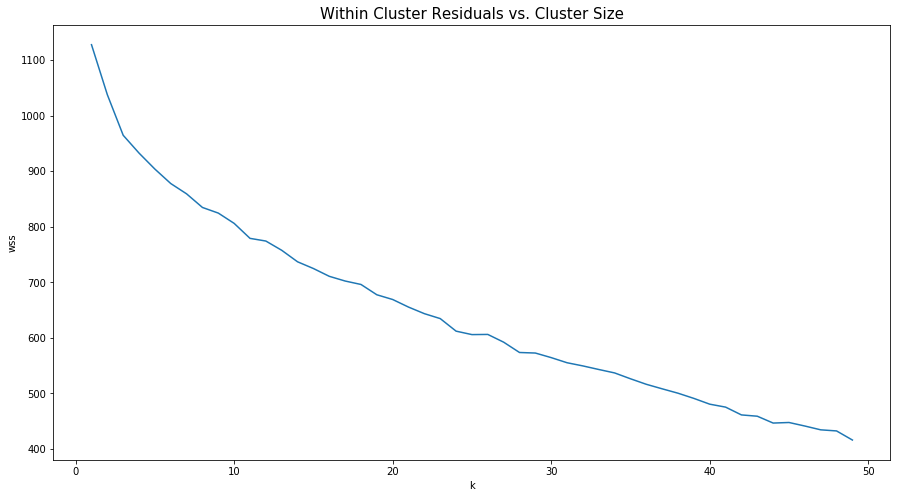

In [28]:
fig, ax = plt.subplots(figsize = (15, 8))
lp = sns.lineplot(x = 'k', y = 'wss', data = smr_k_means)
lp.set_title('Within Cluster Residuals vs. Cluster Size', fontsize = 15)

Will it make sense to use PCA?

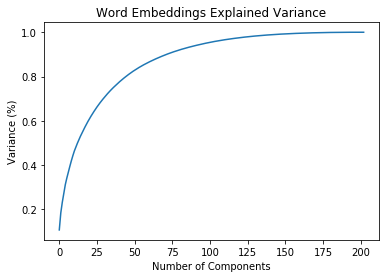

In [29]:
from sklearn.decomposition import PCA

pca = PCA().fit(array_embed)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Word Embeddings Explained Variance')
plt.show()

In [30]:
pca = PCA(n_components=50)
dataset = pca.fit_transform(array_embed)
dataset

array([[-1.2809467 , -0.6374564 ,  0.08567832, ..., -0.2205977 ,
         0.08106195,  0.02594458],
       [-1.0158811 , -0.43711343,  0.6016753 , ..., -0.04733032,
        -0.08249404, -0.02645594],
       [ 0.5145925 , -0.18792501,  0.09462134, ..., -0.11620617,
         0.02083101,  0.03784999],
       ...,
       [ 0.59246707,  0.6864411 , -0.6085653 , ...,  0.11134905,
         0.11028231, -0.04099995],
       [-0.71432245,  0.23490202, -0.5751521 , ...,  0.10448404,
         0.45216638,  0.15103346],
       [-0.6666231 , -0.16419314,  0.20616281, ..., -0.09077871,
         0.5476516 ,  0.5071706 ]], dtype=float32)

In [31]:
n_clusters = range(1,20)
wss = []

for k in n_clusters:
    clust = KMeans(n_clusters = k)
    clust.fit(dataset)
    wss.append(clust.inertia_)

smr_k_means = pd.DataFrame({'k':n_clusters, 'wss':wss})

smr_k_means.head()

,k,wss
0,1,929.294800
1,2,839.453052
2,3,766.582302
3,4,733.542697
4,5,704.498886


Text(0.5, 1.0, 'Within Cluster Residuals vs. Cluster Size')

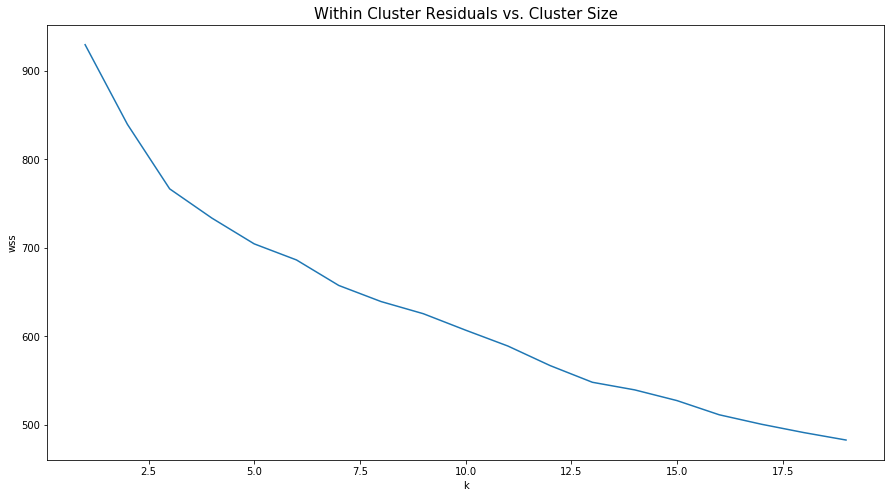

In [32]:
fig, ax = plt.subplots(figsize = (15, 8))
lp = sns.lineplot(x = 'k', y = 'wss', data = smr_k_means)
lp.set_title('Within Cluster Residuals vs. Cluster Size', fontsize = 15)

In [33]:
df_venue_cat = pd.DataFrame({'Venue Category':venue_cat})

cluster_cat = KMeans(n_clusters = 5)
cluster_cat.fit(dataset)
cl = cluster_cat.predict(dataset)
df_venue_cat['Cluster'] = cl

### Examining the venue clusters

In [34]:
df_venue_cat[df_venue_cat['Cluster'] == 0]

,Venue Category,Cluster
5,Video Store,0
10,Coffee Shop,0
14,Paper Office Supplies Store,0
16,Ice Cream Shop,0
17,Bubble Tea Shop,0
22,Dessert Shop,0
23,Food Truck,0
26,Clothing Store,0
33,Frozen Yogurt Shop,0
38,Bookstore,0


In [35]:
df_venue_cat[df_venue_cat['Cluster'] == 1]

,Venue Category,Cluster
0,Baseball Stadium,1
1,College Gym,1
48,Gym Fitness Center,1
62,Gym,1
69,Squash Court,1
146,College Basketball Court,1
150,College Baseball Diamond,1
152,Baseball Field,1
153,Track,1
154,Tennis Stadium,1


In [36]:
df_venue_cat[df_venue_cat['Cluster'] == 2]

,Venue Category,Cluster
2,Juice Bar,2
20,Sports Bar,2
27,Pub,2
32,Bar,2
89,Cocktail Bar,2
94,Nightclub,2
128,Dive Bar,2
131,Wine Bar,2
162,Karaoke Bar,2
169,Hookah Bar,2


In [37]:
df_venue_cat[df_venue_cat['Cluster'] == 3]

,Venue Category,Cluster
4,College Library,3
7,Breakfast Spot,3
8,Bus Station,3
9,Theater,3
12,Food Service,3
...,...,...
190,Historic Site,3
193,Mosque,3
194,Harbor Marina,3
197,Health & Beauty Service,3


In [38]:
df_venue_cat[df_venue_cat['Cluster'] == 4].head(20)

,Venue Category,Cluster
3,Fast Food Restaurant,4
6,Hotel,4
11,Mediterranean Restaurant,4
15,Pizza Place,4
18,Mexican Restaurant,4
19,Greek Restaurant,4
21,Salad Place,4
24,Sushi Restaurant,4
25,Thai Restaurant,4
28,Chinese Restaurant,4


In [39]:
uni_venues = uni_venues.join(df_venue_cat.set_index('Venue Category'), on='Venue Category')

In [40]:
df_venue = pd.DataFrame(uni_venues.groupby('Cluster').count()) \
.rename(columns={"Venue": "Cluster Count"})

df_venue[['Cluster Count']].head(25)

,Cluster Count
Cluster,
0,286
1,52
2,73
3,347
4,344


## Analyze University Areas

In [41]:
uni_venues['Venue Cluster'] = uni_venues.Cluster.apply(str)

# one hot encoding
uni_onehot = pd.get_dummies(uni_venues[['Venue Cluster']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uni_onehot['University'] = uni_venues['University'] 

# move University column to the first column
fixed_columns = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns]

uni_onehot.head()

,University,0,1,2,3,4
0,"Utah Valley University, Orem, UT, USA",0,1,0,0,0
1,"Utah Valley University, Orem, UT, USA",0,1,0,0,0
2,"Utah Valley University, Orem, UT, USA",0,0,1,0,0
3,"Utah Valley University, Orem, UT, USA",0,0,0,0,1
4,"Utah Valley University, Orem, UT, USA",0,0,0,1,0


Let's create a *pandas* dataframe that contains the 5 most common venues per university.

In [43]:
def ordinal(value):
    try:
        value = int(value)
    except ValueError:
        return value

    if value % 100//10 != 1:
        if value % 10 == 1:
            ordval = u"%d%s" % (value, "st")
        elif value % 10 == 2:
            ordval = u"%d%s" % (value, "nd")
        elif value % 10 == 3:
            ordval = u"%d%s" % (value, "rd")
        else:
            ordval = u"%d%s" % (value, "th")
    else:
        ordval = u"%d%s" % (value, "th")

    return ordval

In [44]:
uni_grp = uni_venues.groupby(['University', 'Venue Category']) \
.size().reset_index().rename(columns = {0:'Count'}) \
.groupby(['University', 'Count']) \
.apply(lambda x: ', '.join(x['Venue Category'])) \
.reset_index().rename(columns = {0:'Venue'}) \
.sort_values(by = ['University', 'Count'], axis = 0, ascending = False)

uni_grp['Rank_'] = uni_grp.groupby('University').cumcount() + 1
uni_grp['Venue_Rank'] = uni_grp.Rank_.apply(ordinal)

In [45]:
uni_grp.head()

,University,Count,Venue,Rank_,Venue_Rank
119,"Villanova University, Villanova, PA, USA",1,"Coffee Shop, College Basketball Court, College...",1,1st
118,"Utah Valley University, Orem, UT, USA",2,Fast Food Restaurant,1,1st
117,"Utah Valley University, Orem, UT, USA",1,"Baseball Stadium, Breakfast Spot, Bus Station,...",2,2nd
116,"University of Washington, Seattle, WA, USA",3,Coffee Shop,1,1st
115,"University of Washington, Seattle, WA, USA",2,Bus Station,2,2nd


In [46]:
uni_grp_pivot = uni_grp.query('Rank_ <= 5') \
.pivot(index = 'University', columns = 'Venue_Rank', values = 'Venue') \
.reset_index()

del uni_grp_pivot.columns.name

uni_grp_pivot.head()

,University,1st,2nd,3rd,4th,5th
0,"Arizona State University, Tempe, AZ, USA",Food Service,"Coffee Shop, Middle Eastern Restaurant, Pizza ...","Arts & Crafts Store, Asian Restaurant, Athleti...",NaN,NaN
1,"Auburn University, Auburn, AL, USA",Park,"Coffee Shop, Farmers Market",NaN,NaN,NaN
2,"Boise State University, Boise, ID, US",Hotel,"Bagel Shop, Breakfast Spot, Coffee Shop, Colle...",NaN,NaN,NaN
3,"Brown University, Providence, RI, USA",Food Service,"Coffee Shop, Korean Restaurant","American Restaurant, Art Gallery, Bagel Shop, ...","Asian Restaurant, Bar, Bookstore, Bubble Tea S...",NaN
4,"California Institute of Technology, Pasadena, ...",Café,"Beer Place, Coffee Shop, Food Truck, Fountain,...",NaN,NaN,NaN


## Clustering Universities

Let's use *k*-means clustering to group the universities.

In [47]:
uni_group = uni_onehot.groupby('University').mean().reset_index()

In [48]:
# set number of clusters
kclusters = 4

uni_grouped_clustering = uni_group.drop('University', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(uni_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 3, 3, 1, 1, 2, 3, 3, 1])

In [49]:
# add clustering labels
uni_grp_pivot.insert(0, 'Cluster Labels', kmeans.labels_)

uni_merged = uni_coord

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
uni_merged = uni_merged.join(uni_grp_pivot.set_index('University'), on='University')

uni_merged.head()

,University,Latitude,Longitude,Cluster Labels,1st,2nd,3rd,4th,5th
0,"Utah Valley University, Orem, UT, USA",40.277779,-111.713890,1.0,Fast Food Restaurant,"Baseball Stadium, Breakfast Spot, Bus Station,...",NaN,NaN,NaN
1,"Indiana University of Pennsylvania, Indiana, P...",40.617001,-79.160004,3.0,Fast Food Restaurant,"Coffee Shop, Paper Office Supplies Store","Food Service, Mediterranean Restaurant, Pizza ...",NaN,NaN
2,"University of Illinois, Champign - Urbana, Ili...",40.110558,-88.228333,3.0,Coffee Shop,Chinese Restaurant,"Korean Restaurant, Mexican Restaurant, Sandwic...",Pizza Place,"Bagel Shop, Bakery, Bar, Clothing Store, Ice C..."
3,"Massachusetts Institute of Technology, Cambrid...",42.360001,-71.092003,3.0,Coffee Shop,"College Gym, Park, Pizza Place","Art Gallery, Bakery, Burrito Place, Café, Coll...",NaN,NaN
4,"Stanford University, CA, USA",37.428230,-122.168861,1.0,"Coffee Shop, Fountain","Café, Sculpture Garden","Monument Landmark, Sandwich Place","Bank, Bus Line, Chinese Restaurant, College Bo...",NaN


In [50]:
uni_merged = uni_merged.dropna(subset = ['Cluster Labels'])
uni_merged['Cluster Labels'] = uni_merged['Cluster Labels'].apply(np.int64)

Let's visualize the clusters.

In [51]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(uni_merged['Latitude'], uni_merged['Longitude'], uni_merged['University'], uni_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the Clusters

### Cluster 0

In [52]:
uni_merged.loc[uni_merged['Cluster Labels'] == 0, uni_merged.columns[[0] + list(range(4, uni_merged.shape[1]))]]

,University,1st,2nd,3rd,4th,5th
7,"University of Chicago, Chicago, IL, USA",Café,Coffee Shop,"Bookstore, Food Truck, Sandwich Place",History Museum,"Art Museum, Cafeteria, College Cafeteria, Coll..."
10,"The University of Massachusetts, Amherst, MA, USA",Coffee Shop,"Bus Stop, Café","College Arts Building, College Cafeteria, Conv...",NaN,NaN
19,"Madonna University, Livonia, MI, USA","Coffee Shop, Sandwich Place",NaN,NaN,NaN,NaN
35,"Auburn University, Auburn, AL, USA",Park,"Coffee Shop, Farmers Market",NaN,NaN,NaN
42,"Texas Woman's University, Denton, TX, USA","Coffee Shop, College Library, Fast Food Restau...",NaN,NaN,NaN,NaN
43,"James Madison University, Harrisonburg, VA, USA","Bus Station, Coffee Shop, Dessert Shop, Donut ...",NaN,NaN,NaN,NaN
45,"University of Miami, Coral Gables, Florida, USA","Coffee Shop, Pharmacy","Bagel Shop, Chinese Restaurant, Concert Hall, ...","American Restaurant, Art Gallery, Athletics & ...",NaN,NaN


### Cluster 1

In [53]:
uni_merged.loc[uni_merged['Cluster Labels'] == 1, uni_merged.columns[[0] + list(range(4, uni_merged.shape[1]))]]

,University,1st,2nd,3rd,4th,5th
0,"Utah Valley University, Orem, UT, USA",Fast Food Restaurant,"Baseball Stadium, Breakfast Spot, Bus Station,...",NaN,NaN,NaN
4,"Stanford University, CA, USA","Coffee Shop, Fountain","Café, Sculpture Garden","Monument Landmark, Sandwich Place","Bank, Bus Line, Chinese Restaurant, College Bo...",NaN
6,"California Institute of Technology, Pasadena, ...",Café,"Beer Place, Coffee Shop, Food Truck, Fountain,...",NaN,NaN,NaN
15,"Villanova University, Villanova, PA, USA","Coffee Shop, College Basketball Court, College...",NaN,NaN,NaN,NaN
17,"University of Washington, Seattle, WA, USA",Coffee Shop,Bus Station,"Baseball Field, Beer Place, Bookstore, Café, C...",NaN,NaN
18,"University of North Carolina at Chapel Hill, C...","Coffee Shop, Food Court","Bus Station, Cafeteria, College Baseball Diamo...",NaN,NaN,NaN
26,"University of Nebraska, Lincoln, NE, USA",Coffee Shop,"Art Museum, College Bookstore, College Cafeter...",NaN,NaN,NaN
30,"Texas A&M University, USA",Bar,"Coffee Shop, Food Service",Theater,"Bagel Shop, Bank, Bookstore, Bus Line, Bus Sta...",NaN
33,"The University of Oklahoma, Norman, OK, USA","Café, Chinese Restaurant, Coffee Shop, College...",NaN,NaN,NaN,NaN
34,"Dixie State University, St. George, UT, USA","Beer Place, Food Service, Juice Bar, Pizza Place",NaN,NaN,NaN,NaN


### Cluster 2

In [54]:
uni_merged.loc[uni_merged['Cluster Labels'] == 2, uni_merged.columns[[0] + list(range(4, uni_merged.shape[1]))]]

,University,1st,2nd,3rd,4th,5th
8,"Eastern University, St Davids, PA, USA",College Quad,NaN,NaN,NaN,NaN
13,"Quinnipiac, QU School of Law, Hamden, CT, US","Bus Stop, Coffee Shop, Forest, State Provincia...",NaN,NaN,NaN,NaN
14,Towsley Center for Continuing Medical Educatio...,"Café, Park","Bagel Shop, College Residence Hall, Food Court...",NaN,NaN,NaN
25,"The University of Alabama, Tuscaloosa, AL, USA",Opera House,NaN,NaN,NaN,NaN
27,"Texas Tech University Law Library, Texas Tech ...",Pool,"College Basketball Court, College Cafeteria, C...",NaN,NaN,NaN
40,"Lincoln University, PA, USA","Movie Theater, Theater",NaN,NaN,NaN,NaN
46,"University of Hawaii at Hilo, HI, USA",Theater,NaN,NaN,NaN,NaN


### Cluster 3

In [55]:
uni_merged.loc[uni_merged['Cluster Labels'] == 3, uni_merged.columns[[0] + list(range(4, uni_merged.shape[1]))]]

,University,1st,2nd,3rd,4th,5th
1,"Indiana University of Pennsylvania, Indiana, P...",Fast Food Restaurant,"Coffee Shop, Paper Office Supplies Store","Food Service, Mediterranean Restaurant, Pizza ...",NaN,NaN
2,"University of Illinois, Champign - Urbana, Ili...",Coffee Shop,Chinese Restaurant,"Korean Restaurant, Mexican Restaurant, Sandwic...",Pizza Place,"Bagel Shop, Bakery, Bar, Clothing Store, Ice C..."
3,"Massachusetts Institute of Technology, Cambrid...",Coffee Shop,"College Gym, Park, Pizza Place","Art Gallery, Bakery, Burrito Place, Café, Coll...",NaN,NaN
5,"Harvard University, Cambridge, MA, USA",Café,Pizza Place,"Bookstore, Food Service, Gastropub","American Restaurant, Coffee Shop, Ice Cream Sh...","Art Museum, Bakery, Food Truck, Italian Restau..."
9,"University of Michigan, Ann Arbor, MI, USA",Coffee Shop,"Bar, Pizza Place, Sandwich Place","Food Service, Noodle House","American Restaurant, Café, Chinese Restaurant,...","Arcade, Art Museum, Bagel Shop, Bakery, Caribb..."
11,"Penn State University, State College, PA, USA",Sandwich Place,Bar,"American Restaurant, Clothing Store, Coffee Sh...","Café, Food Service, Ice Cream Shop","Bagel Shop, Bank, Chinese Restaurant, College ..."
12,"Lawrence University, Appleton, WI, USA",Bar,American Restaurant,"ATM, Bagel Shop, Chinese Restaurant, History M...",NaN,NaN
16,"Boise State University, Boise, ID, US",Hotel,"Bagel Shop, Breakfast Spot, Coffee Shop, Colle...",NaN,NaN,NaN
20,"University of California, Santa Barbara, CA, USA",Coffee Shop,"American Restaurant, Bus Station, Chinese Rest...",NaN,NaN,NaN
21,"University of California, Berkeley, CA, USA",Café,Food Service,"Coffee Shop, Sandwich Place","Bubble Tea Shop, Indian Restaurant, Pizza Place","Burrito Place, Clothing Store, Frozen Yogurt S..."
